In [177]:
from autogluon.tabular import TabularDataset, TabularPredictor
from sklearn.model_selection import train_test_split
import pandas as pd

df = pd.read_csv("../../data/AmesHousing.csv")
# df = df.select_dtypes(include="number")
# df.dropna(inplace=True)
# df["random_feature"] = np.random.random(df.shape[0])
# df["Overall Qual Noise"] = df["Overall Qual"] + (df["random_feature"] * 0.0001)

# Split the data
test_size = 0.3
label = "SalePrice"

In [178]:
X_train, X_test, y_train, y_test = train_test_split(
    df.drop(label, axis=1), df[label], test_size=test_size, random_state=42
)

In [179]:
import autogluon

In [180]:
train_data = TabularDataset(X_train)
train_data[label] = y_train
test_data = TabularDataset(X_test)
test_data[label] = y_test

In [300]:
time_limit = 2 * 60  # train various models for ~2 min
num_trials = 40

hyperparameter_tune_kwargs = {  # HPO is not performed unless hyperparameter_tune_kwargs is specified
    "num_trials": num_trials,
    "scheduler": "local",
    "searcher": "bayes",
}

In [335]:
nn_options = {"use_batchnorm" : False}

In [357]:
%%time
predictor = TabularPredictor(label=label, eval_metric="mean_absolute_percentage_error")
predictor.fit(train_data=train_data.head(50), verbosity=2,
              time_limit = 3 * 60,
              #hyperparameters = {"NN_TORCH" : nn_options},
              #hyperparameter_tune_kwargs = hyperparameter_tune_kwargs,
              presets = "high_quality",
              #included_model_types=["NN_TORCH"]
              )

No path specified. Models will be saved in: "AutogluonModels/ag-20240429_143942"
Presets specified: ['high_quality']
Setting dynamic_stacking from 'auto' to True. Reason: Enable dynamic_stacking when use_bag_holdout is disabled. (use_bag_holdout=False)
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=5, num_bag_sets=1
Note: `save_bag_folds=False`! This will greatly reduce peak disk usage during fit (by ~5x), but runs the risk of an out-of-memory error during model refit if memory is small relative to the data size.
	You can avoid this risk by setting `save_bag_folds=True`.
Dynamic stacking is enabled (dynamic_stacking=True). AutoGluon will try to determine whether the input data is affected by stacked overfitting and enable or disable stacking as a consequence.
Detecting stacked overfitting by sub-fitting AutoGluon on the input data. That is, copies of AutoGluon will be sub-fit on subset(s) of the data. Then, the holdout validation data is used to detect stacked

CPU times: user 2min 23s, sys: 2min 10s, total: 4min 33s
Wall time: 3min 3s


In [358]:
predictions = predictor.predict(test_data)

In [359]:
from sklearn.metrics import mean_absolute_percentage_error

In [360]:
mean_absolute_percentage_error(y_test, predictions)

0.13123472905166175

In [361]:
results = predictor.fit_summary(verbosity=10)

*** Summary of fit() ***
Estimated performance of each model:
                              model  score_val                     eval_metric  pred_time_val  fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0               WeightedEnsemble_L2  -0.105783  mean_absolute_percentage_error       0.241090  7.520077                0.000236           0.016265            2      False         22
1         NeuralNetTorch_r22_BAG_L1  -0.114256  mean_absolute_percentage_error       0.060061  2.355069                0.060061           2.355069            1      False          3
2         NeuralNetTorch_r71_BAG_L1  -0.118377  mean_absolute_percentage_error       0.060661  1.400501                0.060661           1.400501            1      False         13
3         NeuralNetTorch_r31_BAG_L1  -0.119597  mean_absolute_percentage_error       0.061488  1.483267                0.061488           1.483267            1      False         11
4        NeuralNetTorch_r121

/Users/giladrubin/mambaforge/envs/ml-env/lib/python3.10/site-packages/autogluon/core/utils/plots.py:169: UserWarning:

AutoGluon summary plots cannot be created because bokeh is not installed. To see plots, please do: "pip install bokeh==2.0.1"



In [379]:
predictor.info()

{'path': 'AutogluonModels/ag-20240429_143942',
 'label': 'SalePrice',
 'random_state': 0,
 'version': '1.1.0',
 'features': ['Order',
  'PID',
  'MS SubClass',
  'MS Zoning',
  'Lot Frontage',
  'Lot Area',
  'Alley',
  'Lot Shape',
  'Land Contour',
  'Lot Config',
  'Land Slope',
  'Neighborhood',
  'Condition 1',
  'Bldg Type',
  'House Style',
  'Overall Qual',
  'Overall Cond',
  'Year Built',
  'Year Remod/Add',
  'Roof Style',
  'Roof Matl',
  'Exterior 1st',
  'Exterior 2nd',
  'Mas Vnr Type',
  'Mas Vnr Area',
  'Exter Qual',
  'Exter Cond',
  'Foundation',
  'Bsmt Qual',
  'Bsmt Cond',
  'Bsmt Exposure',
  'BsmtFin Type 1',
  'BsmtFin SF 1',
  'BsmtFin Type 2',
  'BsmtFin SF 2',
  'Bsmt Unf SF',
  'Total Bsmt SF',
  'Heating',
  'Heating QC',
  'Central Air',
  'Electrical',
  '1st Flr SF',
  '2nd Flr SF',
  'Low Qual Fin SF',
  'Gr Liv Area',
  'Bsmt Full Bath',
  'Bsmt Half Bath',
  'Full Bath',
  'Half Bath',
  'Bedroom AbvGr',
  'Kitchen AbvGr',
  'Kitchen Qual',
  'TotRm

In [362]:
df_hyperparams = pd.DataFrame.from_dict(results["model_hyperparams"], orient="index")
consistent_hyperparams = df_hyperparams.nunique()[df_hyperparams.nunique() == 1].index
df_hyperparams = df_hyperparams.drop(columns=consistent_hyperparams)
df_hyperparams = df_hyperparams.reset_index().rename({"index": "model"}, axis=1).copy()

In [363]:
#remove rows with >4 NAs:
threshold = (df_hyperparams.shape[1] - 1) * 0.8
df_hyperparams = df_hyperparams.dropna(axis=0, thresh=4)

In [364]:
leaderboard = results["leaderboard"]
df = leaderboard.merge(df_hyperparams, on="model")

In [365]:
df

,model,score_val,eval_metric,pred_time_val,fit_time,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order,use_orig_features,save_bag_folds


# Model

In [366]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score

In [367]:
df.columns

Index(['model', 'score_val', 'eval_metric', 'pred_time_val', 'fit_time',
       'pred_time_val_marginal', 'fit_time_marginal', 'stack_level',
       'can_infer', 'fit_order', 'use_orig_features', 'save_bag_folds'],
      dtype='object')

In [368]:
hp_cols = df_hyperparams.columns.tolist()


In [369]:
hp_cols.pop(0)

'model'

In [370]:
# Analyze feature importance
from category_encoders import MEstimateEncoder
from sklearn.pipeline import Pipeline

X = df[hp_cols].copy()
y = df['score_val'].copy()

cat_cols = X.select_dtypes(include=["object", "bool"]).columns.tolist()


In [371]:
df.head()

,model,score_val,eval_metric,pred_time_val,fit_time,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order,use_orig_features,save_bag_folds


In [372]:
#pd.set_option('future.no_silent_downcasting', True)

In [373]:
pd.options.display.max_columns = 100

In [374]:
df

,model,score_val,eval_metric,pred_time_val,fit_time,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order,use_orig_features,save_bag_folds


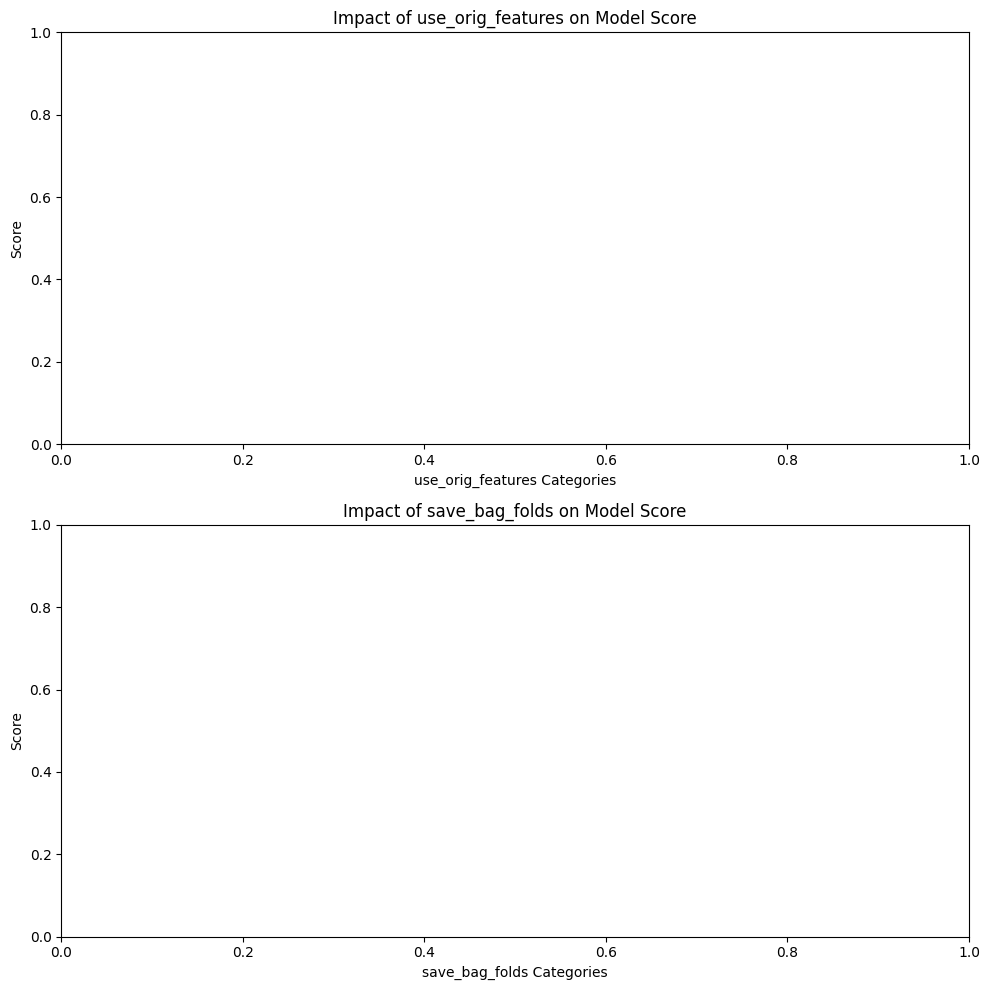

In [375]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
categorical_hps = cat_cols
numeric_hps = list(set(X.columns) - set(cat_cols))
# Plotting
fig, axes = plt.subplots(nrows=len(categorical_hps) + len(numeric_hps), ncols=1, figsize=(10, 5 * (len(categorical_hps) + len(numeric_hps))))

# Box plots for categorical hyperparameters
for idx, hp in enumerate(categorical_hps):
    sns.boxplot(x=hp, y='score_val', data=df, ax=axes[idx])
    axes[idx].set_title(f'Impact of {hp} on Model Score')
    axes[idx].set_xlabel(f'{hp} Categories')
    axes[idx].set_ylabel('Score')

for idx, hp in enumerate(numeric_hps):
    # Adding jitter by adding a small noise to the data
    jittered_x = df[hp] + np.random.normal(0, 0.01, size=len(df))
    sns.scatterplot(x=jittered_x, y='score_val', data=df, alpha=0.5, ax=axes[len(categorical_hps) + idx])  # Adjust alpha for opacity
    axes[len(categorical_hps) + idx].set_title(f'Impact of {hp} on Model Score')
    axes[len(categorical_hps) + idx].set_xlabel(f'{hp} Value')
    axes[len(categorical_hps) + idx].set_ylabel('Score')

plt.tight_layout()
plt.show()


In [376]:
X_enc = pd.get_dummies(X, columns=cat_cols)
from sklearn.tree import DecisionTreeRegressor, plot_tree

# Train the model
model = DecisionTreeRegressor(max_depth=3, random_state=42)  # You can adjust the max_depth as needed
model.fit(X_enc, y)

# Visualize the decision tree
plt.figure(figsize=(20,10))
plot_tree(model, feature_names=X_enc.columns, filled=True, fontsize=10)
plt.title('Decision Tree for Model Hyperparameters with One-Hot Encoding')
plt.show()

ValueError: at least one array or dtype is required

In [149]:
import plotly.express as px

In [150]:
px.scatter(df, x="fit_time", y="score_val", color="model", text="model")